Testing different libraries

Error: 'climate_data.csv' not found. Please create or download it.
Created sample 'data/climate_data.csv' for testing.


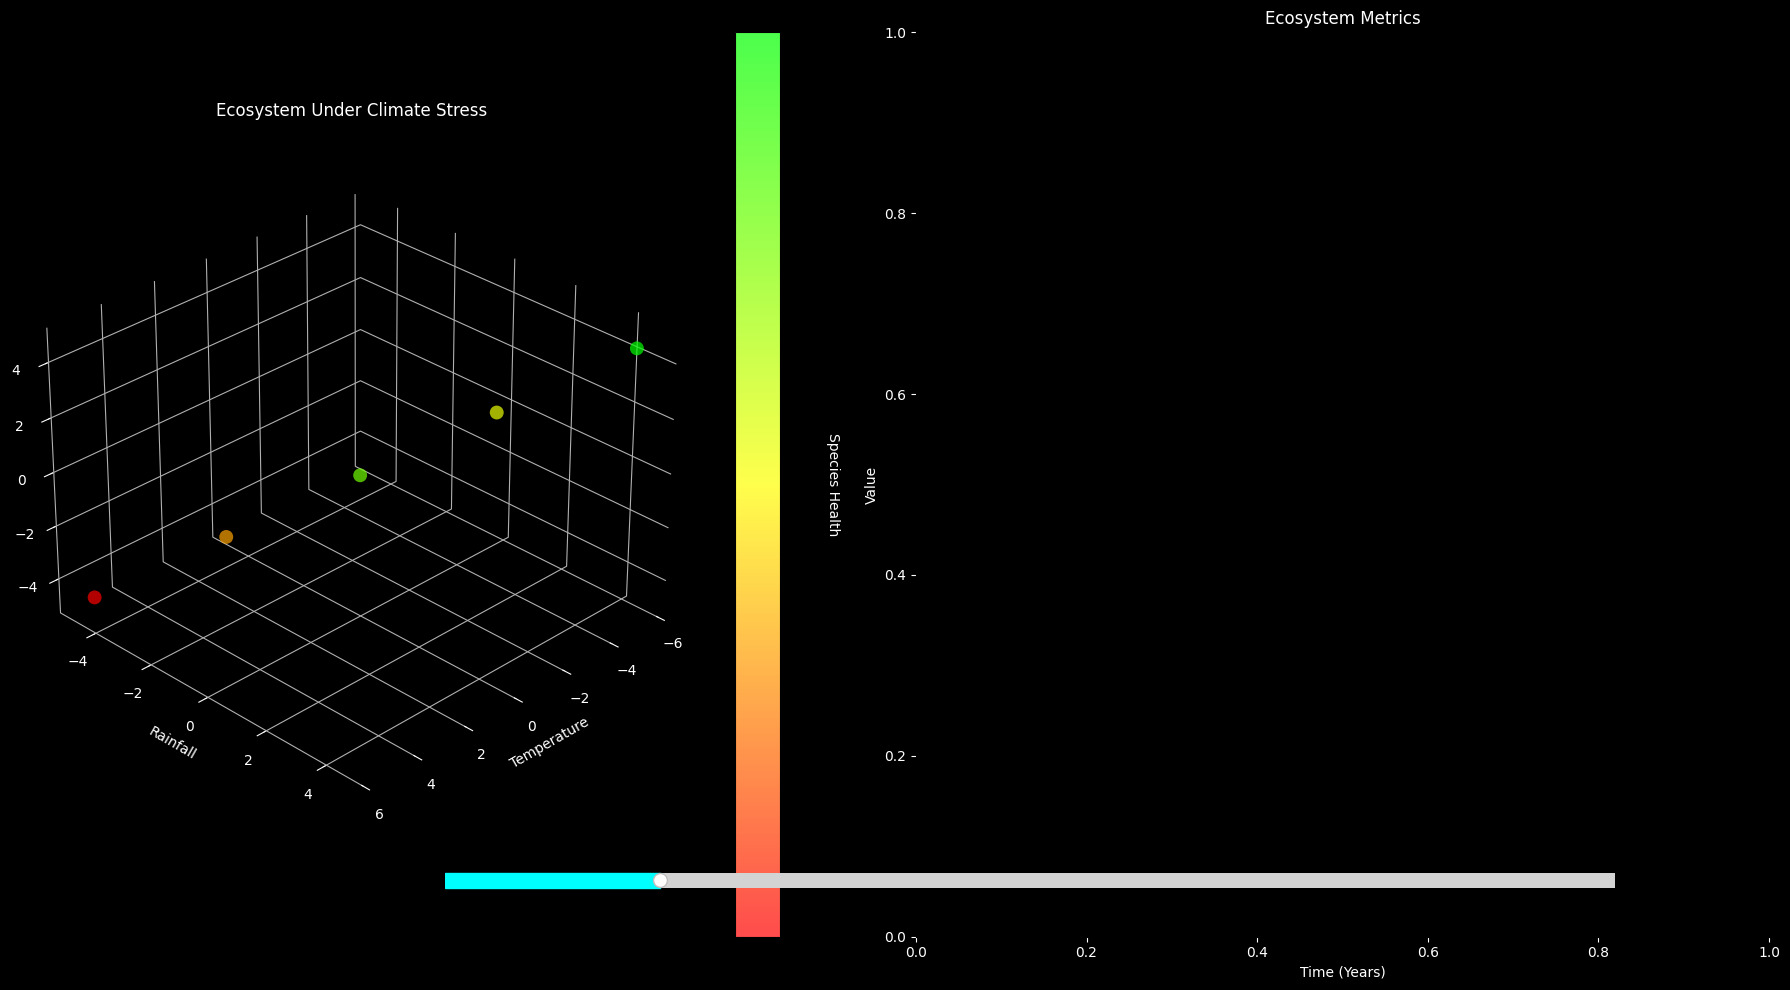

Simulation complete. Analyzing ecosystem health...


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings("ignore")

# Load data from CSV
try:
    data = pd.read_csv('data/climate_data.csv')
except FileNotFoundError:
    print("Error: 'climate_data.csv' not found. Please create or download it.")
    # Use sample data as fallback
    sample_data = {
        'Year': [2000, 2001, 2002, 2003, 2004],
        'Temperature': [15.2, 15.5, 15.8, 16.1, 16.4],
        'Rainfall': [800, 780, 760, 740, 720],
        'Habitat_Quality': [0.8, 0.75, 0.7, 0.65, 0.6],
        'CO2': [370, 372, 375, 380, 385],
        'Species_Population': [1000, 990, 980, 970, 960]
    }
    data = pd.DataFrame(sample_data)
    data.to_csv('data/climate_data.csv', index=False)
    print("Created sample 'data/climate_data.csv' for testing.")

years = data['Year'].values
temp = data['Temperature'].values
rain = data['Rainfall'].values
habitat = data['Habitat_Quality'].values
co2 = data['CO2'].values
populations = data['Species_Population'].values

# Normalize data
env_size = 10
temp_norm = (temp - temp.min()) / (temp.max() - temp.min()) * env_size - env_size/2
rain_norm = (rain - rain.min()) / (rain.max() - rain.min()) * env_size - env_size/2
habitat_norm = (habitat - habitat.min()) / (habitat.max() - habitat.min()) * env_size - env_size/2
co2_norm = (co2 - co2.min()) / (co2.max() - co2.min()) * env_size - env_size/2
pop_norm = populations / populations.max() * 100

# Initialize figure
fig = plt.figure(figsize=(18, 10), facecolor='black')
ax_sim = fig.add_subplot(121, projection='3d', computed_zorder=False)
ax_analysis = fig.add_subplot(122)
plt.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.9, wspace=0.3)

# Parameters
n_species = len(data)
dt = 0.02
disruption_factor = 0.1
co2_effect = 1e-3

# Initial conditions
conditions_4d = np.column_stack([temp_norm, rain_norm, habitat_norm, co2_norm])
adaptations_4d = np.random.normal(0, 0.1, (n_species, 4))
populations = pop_norm
resilience = np.random.uniform(0, 2*np.pi, n_species)

# Stress matrix
stress_matrix = np.random.random((n_species, n_species)) - 0.5
stress_matrix = (stress_matrix + stress_matrix.T) / 2
stress_matrix *= disruption_factor / np.linalg.norm(stress_matrix)

# Initial scatter plot
proj_3d = conditions_4d[:, :3] + gaussian_filter(conditions_4d[:, 3], sigma=1)[:, np.newaxis] * 0.1
sizes = np.clip(populations * 30 + np.sin(resilience) * 10, 5, 100)
health_colors = np.sin(resilience + np.linalg.norm(conditions_4d, axis=1)) + 1
cmap = mcolors.LinearSegmentedColormap.from_list('ecosystem', ['#FF0000', '#FFFF00', '#00FF00'])
scatter = ax_sim.scatter(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], 
                        s=sizes, c=health_colors, cmap=cmap, alpha=0.7, edgecolors='none')

# Colorbar
colorbar = fig.colorbar(scatter, ax=ax_sim)
colorbar.set_label('Species Health', rotation=270, labelpad=20, color='white')

# Axes customization
ax_sim.set_facecolor('black')
for spine in ax_sim.spines.values():
    spine.set_color('white')
ax_sim.xaxis.set_pane_color((0, 0, 0, 0))
ax_sim.yaxis.set_pane_color((0, 0, 0, 0))
ax_sim.zaxis.set_pane_color((0, 0, 0, 0))
ax_sim.tick_params(colors='white')
ax_sim.set_xlabel('Temperature', color='white')
ax_sim.set_ylabel('Rainfall', color='white')
ax_sim.set_zlabel('Habitat Quality', color='white')
ax_sim.set_title('Ecosystem Under Climate Stress', color='white', pad=20)

ax_analysis.set_facecolor('black')
ax_analysis.tick_params(colors='white')
ax_analysis.set_title('Ecosystem Metrics', color='white')
ax_analysis.set_xlabel('Time (Years)', color='white')
ax_analysis.set_ylabel('Value', color='white')

# Data storage
times = []
avg_conditions = []
population_totals = []
extinction_risks = []

# Stress function
def ecosystemStress(conds_4d, adapts_4d, resilience, pops, t):
    diff = conds_4d[:, np.newaxis, :] - conds_4d[np.newaxis, :, :]
    dist = np.linalg.norm(diff, axis=2) + 1e-6
    stress_4d = np.zeros_like(conds_4d)
    res_diff = resilience[:, np.newaxis] - resilience[np.newaxis, :]
    co2_impact = co2_effect * np.sin(res_diff) / dist**2 * (conds_4d[:, 3].mean() + t * 0.01)
    stress_4d += np.sum(diff * co2_impact[..., np.newaxis] * pops[np.newaxis, :, np.newaxis], axis=1)
    human_impact = stress_matrix @ (conds_4d * np.cos(t) + adapts_4d * np.sin(t))
    stress_4d += human_impact
    return stress_4d

# Update function
def update(frame, disruption_slider):
    global conditions_4d, adaptations_4d, resilience, stress_matrix, populations
    
    t = frame * dt
    stresses_4d = ecosystemStress(conditions_4d, adaptations_4d, resilience, populations, t)
    adaptations_4d += stresses_4d * dt / populations[:, np.newaxis]
    adaptations_4d *= np.exp(-disruption_slider.val * dt)
    conditions_4d += adaptations_4d * dt
    
    resilience += np.linalg.norm(adaptations_4d, axis=1) * dt - conditions_4d[:, 3] * 0.001
    populations *= np.clip(np.cos(resilience) + 1, 0, 1)
    
    stress_matrix += np.random.normal(0, 0.001, stress_matrix.shape) * disruption_slider.val
    stress_matrix = (stress_matrix + stress_matrix.T) / 2
    stress_matrix *= disruption_factor / np.linalg.norm(stress_matrix)
    
    proj_3d = conditions_4d[:, :3] + gaussian_filter(conditions_4d[:, 3], sigma=1)[:, np.newaxis] * 0.1
    sizes = np.clip(populations * 30 + np.sin(resilience + t) * 10, 5, 100)
    health_colors = np.sin(resilience + np.linalg.norm(conditions_4d, axis=1)) + 1
    scatter._offsets3d = (proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2])
    scatter.set_sizes(sizes)
    scatter.set_array(health_colors)
    
    ax_sim.set_xlim(np.min(proj_3d[:, 0]) - 1, np.max(proj_3d[:, 0]) + 1)
    ax_sim.set_ylim(np.min(proj_3d[:, 1]) - 1, np.max(proj_3d[:, 1]) + 1)
    ax_sim.set_zlim(np.min(proj_3d[:, 2]) - 1, np.max(proj_3d[:, 2]) + 1)
    
    avg_cond = np.mean(np.linalg.norm(conditions_4d[:, :3], axis=1))
    total_pop = np.sum(populations)
    risk_fraction = np.mean(populations < 0.1)
    
    times.append(t + years[0])
    avg_conditions.append(avg_cond)
    population_totals.append(total_pop)
    extinction_risks.append(risk_fraction)
    
    ax_analysis.clear()
    ax_analysis.plot(times, avg_conditions, label='Avg Env Deviation', color='cyan')
    ax_analysis.plot(times, population_totals, label='Total Population', color='magenta')
    ax_analysis.plot(times, extinction_risks, label='Extinction Risk', color='yellow')
    ax_analysis.legend(loc='upper right', facecolor='black', edgecolor='white', labelcolor='white')
    ax_analysis.set_facecolor('black')
    ax_analysis.tick_params(colors='white')
    ax_analysis.set_title('Ecosystem Metrics', color='white')
    ax_analysis.set_xlabel('Time (Years)', color='white')
    ax_analysis.set_ylabel('Value', color='white')
    
    return scatter,

# Slider
ax_disrupt = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor='gray')
disruption_slider = Slider(ax_disrupt, 'Disruption Level', 0.01, 0.5, valinit=0.1, color='cyan')

# Animation
ani = FuncAnimation(fig, update, frames=range(1000), fargs=(disruption_slider,), interval=20, blit=False)

# Aesthetics
ax_sim.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

# Analysis
print("Simulation complete. Analyzing ecosystem health...")
if len(times) > 10:
    pop_decline = (population_totals[0] - population_totals[-1]) / population_totals[0] * 100
    risk_trend = np.polyfit(times, extinction_risks, 1)[0]
    print(f"Population Decline: {pop_decline:.2f}%")
    print(f"Extinction Risk Trend (slope): {risk_trend:.4f}")
    if pop_decline > 50:
        print("Alert: Ecosystem collapse detected—urgent action needed!")
    if risk_trend > 0.001:
        print("Alert: Accelerating extinction risk—mitigate CO2 and disruption!")

https://climateknowledgeportal.worldbank.org/download-data